In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 935, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 935 (delta 48), reused 47 (delta 36), pack-reused 860 (from 2)
Receiving objects: 100% (935/935), 28.29 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (532/532), done.
Updating files: 100% (119/119), done.
Filtering content: 100% (32/32), 1.75 GiB | 44.49 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install ta
!pip install pykalman
!pip install PyWavelets

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=be129de98400aab48954742b6ade25516aeb376091799a618bf8fe6b7085747b
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 11.2 MB/s eta 0:00:00


In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported

In [9]:
# Goal: Compare profitability of random pairs picking to currently used method.
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01' # possibly change to 07-01 (option 1; dev data in end_year - 1 (e.g. 2023), test data in end_year (e.g. 2024) // option 2; dev data 1st half end_year, test data 2nd half end_year)
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.


num_results = min(30, len(pairs_data_filtered))
gt_yoy_list = []
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    gt_yoy_list.append(gt_yoy)

Gathering [...]:   0%|          | 0/30 [00:00<?, ?it/s]

In [19]:
import random

gt_yoy_list_random = []

target_col = "Close"
tickers = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()
# loop through all possible pairs of tickers
keys = list(tickers)
all_pairs = [(keys[i], keys[j]) for i in range(len(keys)) for j in range(i+1, len(keys))]
random_pairs = random.sample(all_pairs, 100)

for i in tqdm(range(len(random_pairs)), desc = "Gathering [...]"):
    ticker_a, ticker_b = random_pairs[i][0], random_pairs[i][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    gt_yoy_list_random.append(gt_yoy)

Gathering [...]:   0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
average_gt_yoy, std_dev_gt_yoy = np.mean(gt_yoy_list), np.std(gt_yoy_list)
average_gt_yoy_random, std_dev_gt_yoy_random = np.mean(gt_yoy_list_random), np.std(gt_yoy_list_random)
average_gt_yoy, std_dev_gt_yoy, average_gt_yoy_random, std_dev_gt_yoy_random

(np.float64(2.2946041473966923),
 np.float64(7.2616651780497135),
 np.float64(8.769745042562105),
 np.float64(26.65266518607185))

In [18]:
for gt_yoy in gt_yoy_list:
  print(gt_yoy)

0.03312723374670545
-1.0
0.11610257589199224
0.013804674746521028
-1.0
-0.6321036732423827
-1.0
14.824909634961765
4.553133609407849
-1.0
0.06347301768576696
-1.0
2.62449663825771
35.6611333872715
0.028841585430884553
-1.0
3.8923819264565243
-1.0
-1.0
-0.5846440051600278
10.393880118333026
-1.0
-1.0
0.012437652722827597
-1.0
9.011409563125854
-1.0
-1.0
1.6127266062937657
0.21301387597050558


(array([24.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.        ,  2.66611334,  6.33222668,  9.99834002, 13.66445335,
        17.33056669, 20.99668003, 24.66279337, 28.32890671, 31.99502005,
        35.66113339]),
 <BarContainer object of 10 artists>)

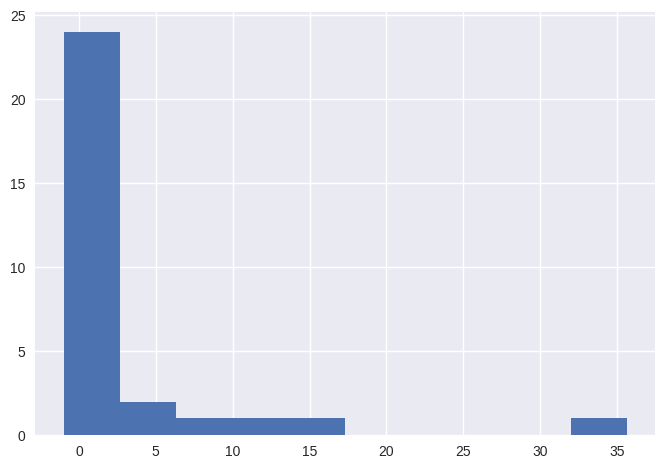

In [11]:
plt.hist(gt_yoy_list)